# Structural Analyses

In [3]:
import requests
import glob
import gzip
import re
import os
import sys
import numpy as np
import pandas as pd
import py3Dmol
import polars as pl
from Bio.PDB import PDBParser
from Bio.SubsMat import MatrixInfo

GENE = "F9"
FEAT_SETS = ["GFP", "DNA", "AGP", "Mito", "Morph"]

# 3-letter to 1-letter AA conversion dictionary
three_to_one = {
    'ALA':'A', 'ARG':'R', 'ASN':'N', 'ASP':'D', 'CYS':'C',
    'GLN':'Q', 'GLU':'E', 'GLY':'G', 'HIS':'H', 'ILE':'I',
    'LEU':'L', 'LYS':'K', 'MET':'M', 'PHE':'F', 'PRO':'P',
    'SER':'S', 'THR':'T', 'TRP':'W', 'TYR':'Y', 'VAL':'V'
}

# Load BLOSUM62 matrix from Biopython
blosum62 = MatrixInfo.blosum62

def blosum62_score(wt, mut):
    key = (wt.upper(), mut.upper())
    if key not in blosum62:
        key = (mut.upper(), wt.upper())
    return blosum62.get(key)


miyata_dist = {
    'A':{'A':0.00,'R':0.91,'N':0.83,'D':0.88,'C':1.27,'Q':0.93,'E':0.94,'G':0.60,'H':1.00,'I':1.27,'L':1.23,'K':0.99,'M':1.05,'F':1.49,'P':0.74,'S':0.58,'T':0.64,'W':1.85,'Y':1.47,'V':1.14},
    'R':{'A':0.91,'R':0.00,'N':0.77,'D':1.04,'C':1.68,'Q':0.21,'E':0.44,'G':1.27,'H':0.39,'I':1.60,'L':1.54,'K':0.25,'M':1.39,'F':1.68,'P':0.95,'S':0.87,'T':1.12,'W':1.45,'Y':1.19,'V':1.54},
    'N':{'A':0.83,'R':0.77,'N':0.00,'D':0.24,'C':1.57,'Q':0.42,'E':0.54,'G':0.80,'H':0.56,'I':1.64,'L':1.65,'K':0.80,'M':1.59,'F':1.95,'P':1.13,'S':0.26,'T':0.37,'W':2.08,'Y':1.72,'V':1.49},
    'D':{'A':0.88,'R':1.04,'N':0.24,'D':0.00,'C':1.84,'Q':0.94,'E':0.22,'G':0.89,'H':0.89,'I':1.89,'L':1.83,'K':0.89,'M':1.76,'F':2.16,'P':1.38,'S':0.50,'T':0.82,'W':2.15,'Y':1.79,'V':1.66},
    'C':{'A':1.27,'R':1.68,'N':1.57,'D':1.84,'C':0.00,'Q':1.89,'E':1.90,'G':1.70,'H':1.42,'I':1.18,'L':1.08,'K':1.89,'M':1.04,'F':1.48,'P':1.94,'S':1.16,'T':1.30,'W':1.81,'Y':1.36,'V':1.07},
    'Q':{'A':0.93,'R':0.21,'N':0.42,'D':0.94,'C':1.89,'Q':0.00,'E':0.29,'G':1.31,'H':0.45,'I':1.55,'L':1.47,'K':0.28,'M':1.24,'F':1.59,'P':1.03,'S':0.74,'T':0.90,'W':1.57,'Y':1.20,'V':1.48},
    'E':{'A':0.94,'R':0.44,'N':0.54,'D':0.22,'C':1.90,'Q':0.29,'E':0.00,'G':1.09,'H':0.73,'I':1.66,'L':1.60,'K':0.42,'M':1.44,'F':1.85,'P':1.22,'S':0.60,'T':0.86,'W':1.77,'Y':1.40,'V':1.58},
    'G':{'A':0.60,'R':1.27,'N':0.80,'D':0.89,'C':1.70,'Q':1.31,'E':1.09,'G':0.00,'H':1.40,'I':1.59,'L':1.53,'K':1.28,'M':1.50,'F':1.92,'P':0.75,'S':0.47,'T':0.58,'W':2.08,'Y':1.70,'V':1.34},
    'H':{'A':1.00,'R':0.39,'N':0.56,'D':0.89,'C':1.42,'Q':0.45,'E':0.73,'G':1.40,'H':0.00,'I':1.71,'L':1.67,'K':0.56,'M':1.52,'F':1.69,'P':1.32,'S':0.90,'T':1.06,'W':1.25,'Y':0.96,'V':1.66},
    'I':{'A':1.27,'R':1.60,'N':1.64,'D':1.89,'C':1.18,'Q':1.55,'E':1.66,'G':1.59,'H':1.71,'I':0.00,'L':0.04,'K':1.62,'M':0.16,'F':0.39,'P':1.65,'S':1.21,'T':1.04,'W':1.84,'Y':1.46,'V':0.23},
    'L':{'A':1.23,'R':1.54,'N':1.65,'D':1.83,'C':1.08,'Q':1.47,'E':1.60,'G':1.53,'H':1.67,'I':0.04,'L':0.00,'K':1.57,'M':0.22,'F':0.61,'P':1.59,'S':1.14,'T':1.01,'W':1.77,'Y':1.39,'V':0.32},
    'K':{'A':0.99,'R':0.25,'N':0.80,'D':0.89,'C':1.89,'Q':0.28,'E':0.42,'G':1.28,'H':0.56,'I':1.62,'L':1.57,'K':0.00,'M':1.41,'F':1.73,'P':1.07,'S':0.63,'T':0.83,'W':1.55,'Y':1.18,'V':1.53},
    'M':{'A':1.05,'R':1.39,'N':1.59,'D':1.76,'C':1.04,'Q':1.24,'E':1.44,'G':1.50,'H':1.52,'I':0.16,'L':0.22,'K':1.41,'M':0.00,'F':0.60,'P':1.44,'S':1.10,'T':1.03,'W':1.84,'Y':1.43,'V':0.38},
    'F':{'A':1.49,'R':1.68,'N':1.95,'D':2.16,'C':1.48,'Q':1.59,'E':1.85,'G':1.92,'H':1.69,'I':0.39,'L':0.61,'K':1.73,'M':0.60,'F':0.00,'P':1.90,'S':1.56,'T':1.57,'W':1.28,'Y':0.38,'V':0.67},
    'P':{'A':0.74,'R':0.95,'N':1.13,'D':1.38,'C':1.94,'Q':1.03,'E':1.22,'G':0.75,'H':1.32,'I':1.65,'L':1.59,'K':1.07,'M':1.44,'F':1.90,'P':0.00,'S':0.75,'T':0.76,'W':2.19,'Y':1.76,'V':1.34},
    'S':{'A':0.58,'R':0.87,'N':0.26,'D':0.50,'C':1.16,'Q':0.74,'E':0.60,'G':0.47,'H':0.90,'I':1.21,'L':1.14,'K':0.63,'M':1.10,'F':1.56,'P':0.75,'S':0.00,'T':0.17,'W':1.88,'Y':1.53,'V':1.07},
    'T':{'A':0.64,'R':1.12,'N':0.37,'D':0.82,'C':1.30,'Q':0.90,'E':0.86,'G':0.58,'H':1.06,'I':1.04,'L':1.01,'K':0.83,'M':1.03,'F':1.57,'P':0.76,'S':0.17,'T':0.00,'W':1.92,'Y':1.56,'V':0.90},
    'W':{'A':1.85,'R':1.45,'N':2.08,'D':2.15,'C':1.81,'Q':1.57,'E':1.77,'G':2.08,'H':1.25,'I':1.84,'L':1.77,'K':1.55,'M':1.84,'F':1.28,'P':2.19,'S':1.88,'T':1.92,'W':0.00,'Y':0.58,'V':1.64},
    'Y':{'A':1.47,'R':1.19,'N':1.72,'D':1.79,'C':1.36,'Q':1.20,'E':1.40,'G':1.70,'H':0.96,'I':1.46,'L':1.39,'K':1.18,'M':1.43,'F':0.38,'P':1.76,'S':1.53,'T':1.56,'W':0.58,'Y':0.00,'V':1.26},
    'V':{'A':1.14,'R':1.54,'N':1.49,'D':1.66,'C':1.07,'Q':1.48,'E':1.58,'G':1.34,'H':1.66,'I':0.23,'L':0.32,'K':1.53,'M':0.38,'F':0.67,'P':1.34,'S':1.07,'T':0.90,'W':1.64,'Y':1.26,'V':0.00}
}

# max_dist = max(max(row.values()) for row in miyata_dist.values())
def miyata_score(wt, mut):
    wt = wt.upper()
    mut = mut.upper()
    if wt not in miyata_dist or mut not in miyata_dist[wt]:
        return None  # Unknown AA
    dist = miyata_dist[wt][mut]
    # Convert distance to similarity (higher score = more similar)
    return dist

In [24]:
imaging_summary_clinvar = pl.read_csv("../../3_outputs/2_results_summary/imaging_analyses_summary_clinvar.tsv", separator="\t", infer_schema_length=100000).with_columns(
    pl.col("symbol").str.replace_all(r"[^a-zA-Z0-9]", "").alias("symbol"),
    pl.col("plddt").cast(pl.Float32).alias("plddt_f32"),
    pl.col("rsa").cast(pl.Float32).alias("rsa_f32")
).with_columns(
    (
        pl.when(pl.col("rsa_f32")<.1)
        .then(pl.lit("<10"))
        .when(pl.col("rsa_f32")>=.9)
        .then(pl.lit("$\geqslant$90"))
        .otherwise(pl.lit("10-90"))
    ).alias("RSA_Category"),
    (
        pl.when(pl.col("plddt_f32")<=50)
        .then(pl.lit("<=50"))
        .when((pl.col("plddt_f32")>50)&(pl.col("plddt_f32")<=70))
        .then(pl.lit("50-70"))
        .when((pl.col("plddt_f32")>70)&(pl.col("plddt_f32")<=90))
        .then(pl.lit("70-90"))
        .otherwise(pl.lit(">90"))
    ).alias("pLDDT_Category")
)
imaging_summary_clinvar_gene = imaging_summary_clinvar.filter(pl.col("symbol")==GENE)

<Axes: xlabel='RSA_Category', ylabel='AUROC_Mean_GFP'>

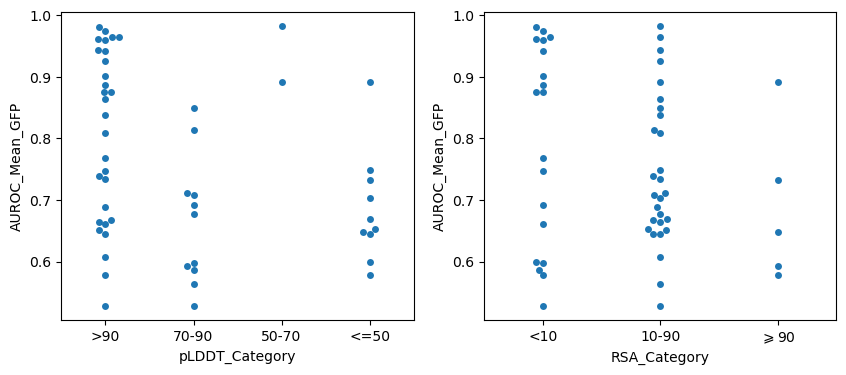

In [32]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
sns.swarmplot(
    data=imaging_summary_clinvar_gene.to_pandas(),
    x="pLDDT_Category",
    y="AUROC_Mean_GFP",
    order=[">90","70-90","50-70","<=50"],
    ax=axes[0]
)
sns.swarmplot(
    data=imaging_summary_clinvar_gene.to_pandas(),
    x="RSA_Category",
    y="AUROC_Mean_GFP",
    order=["<10","10-90","$\geqslant$90"],
    ax=axes[1]
)

In [11]:
sys.path.append("../../..")
from g2p import *

ccm2_genome2protein_feat_file = "../../../G2P_F9_P00740_protein_features.tsv"
validate_variants_against_protein_features(imaging_summary_clinvar.filter(pl.col("symbol")==GENE).to_pandas(), ccm2_genome2protein_feat_file)
imaging_summary_prot_df = extract_protein_features_for_variants(imaging_summary_clinvar.filter(pl.col("symbol")==GENE).to_pandas(), ccm2_genome2protein_feat_file)

  ✓ Added 78 protein feature columns


In [55]:
# imaging_summary_prot_df[imaging_summary_prot_df['protein_Signal (UniProt)']=="Signal"]

In [54]:
# imaging_summary_prot_df[imaging_summary_prot_df['protein_Domain (UniProt)']=='Peptidase S1'].sort_values("AUROC_Mean_GFP", ascending=False)[["gene_allele","AUROC_Mean_GFP"]]

<Axes: xlabel='pLDDT', ylabel='AUROC_Mean_GFP'>

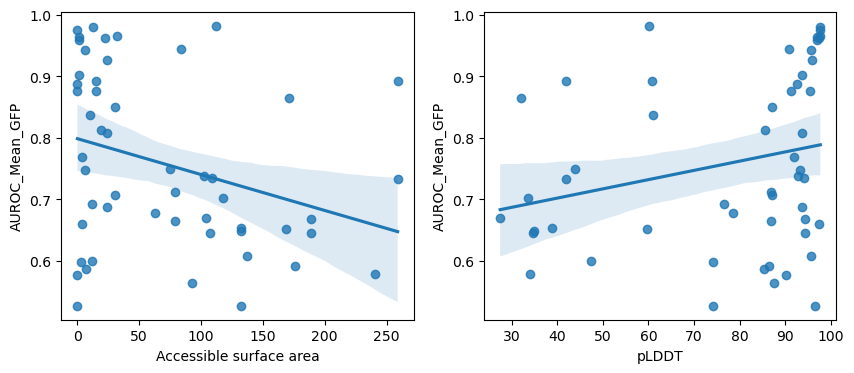

In [48]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
imaging_summary_prot_df_p = pl.DataFrame(imaging_summary_prot_df).with_columns(
    pl.col('protein_Accessible surface area (Å²)*').cast(pl.Float64).alias("Accessible surface area"),
    pl.col('protein_AlphaFold confidence (pLDDT)').cast(pl.Float64).alias("pLDDT"),
).to_pandas()
sns.regplot(
    data=imaging_summary_prot_df_p,
    x='Accessible surface area',
    y="AUROC_Mean_GFP",
    # order=[">90","70-90","50-70","<=50"],
    ax=axes[0]
)
sns.regplot(
    data=imaging_summary_prot_df_p,
    x='pLDDT',
    y="AUROC_Mean_GFP",
    # order=["<10","10-90","$\geqslant$90"],
    ax=axes[1]
)

Feature Categories for Subcellular Localization Analysis:

Signal Sequences Targeting:
  - protein_Signal (UniProt)

Structural Context:
  - protein_Hydropathy
  - protein_Secondary structure (DSSP 3-state)*
  - protein_Secondary structure (DSSP 9-state)*
  - protein_Accessible surface area (Å²)*
  - protein_AlphaFold confidence (pLDDT)

Protein Domains Sites:
  - protein_Domain (UniProt)
  - protein_Active site (UniProt)
  - protein_Binding site (UniProt)

Dataset shape: (52, 913)
AUROC_Mean_GFP range: 0.527 - 0.982
Altered_95th_perc_both_batches_GFP categories: Altered_95th_perc_both_batches_GFP
False    48
True      2
Name: count, dtype: int64

ANALYZING: Signal Sequences Targeting


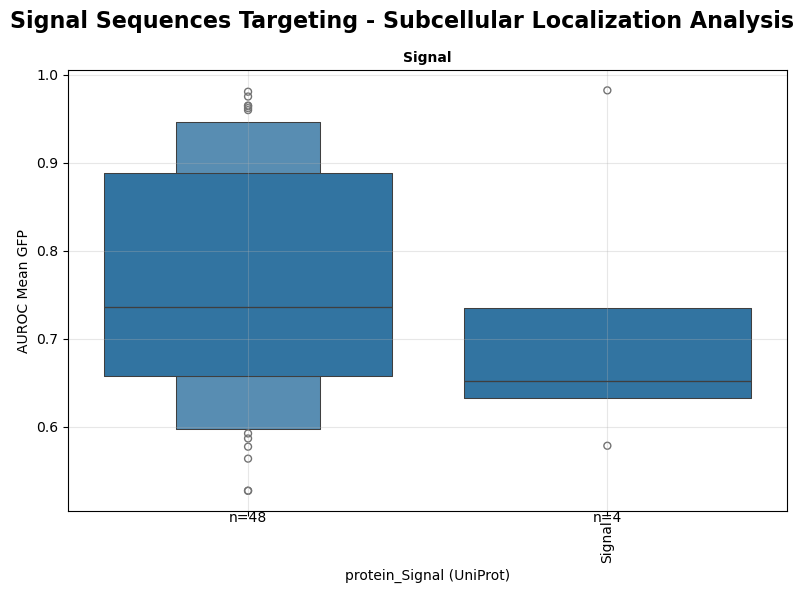


Signal Sequences Targeting Summary:
Features analyzed: 1
  protein_Signal (UniProt): categorical, 52 non-null values

ANALYZING: Structural Context


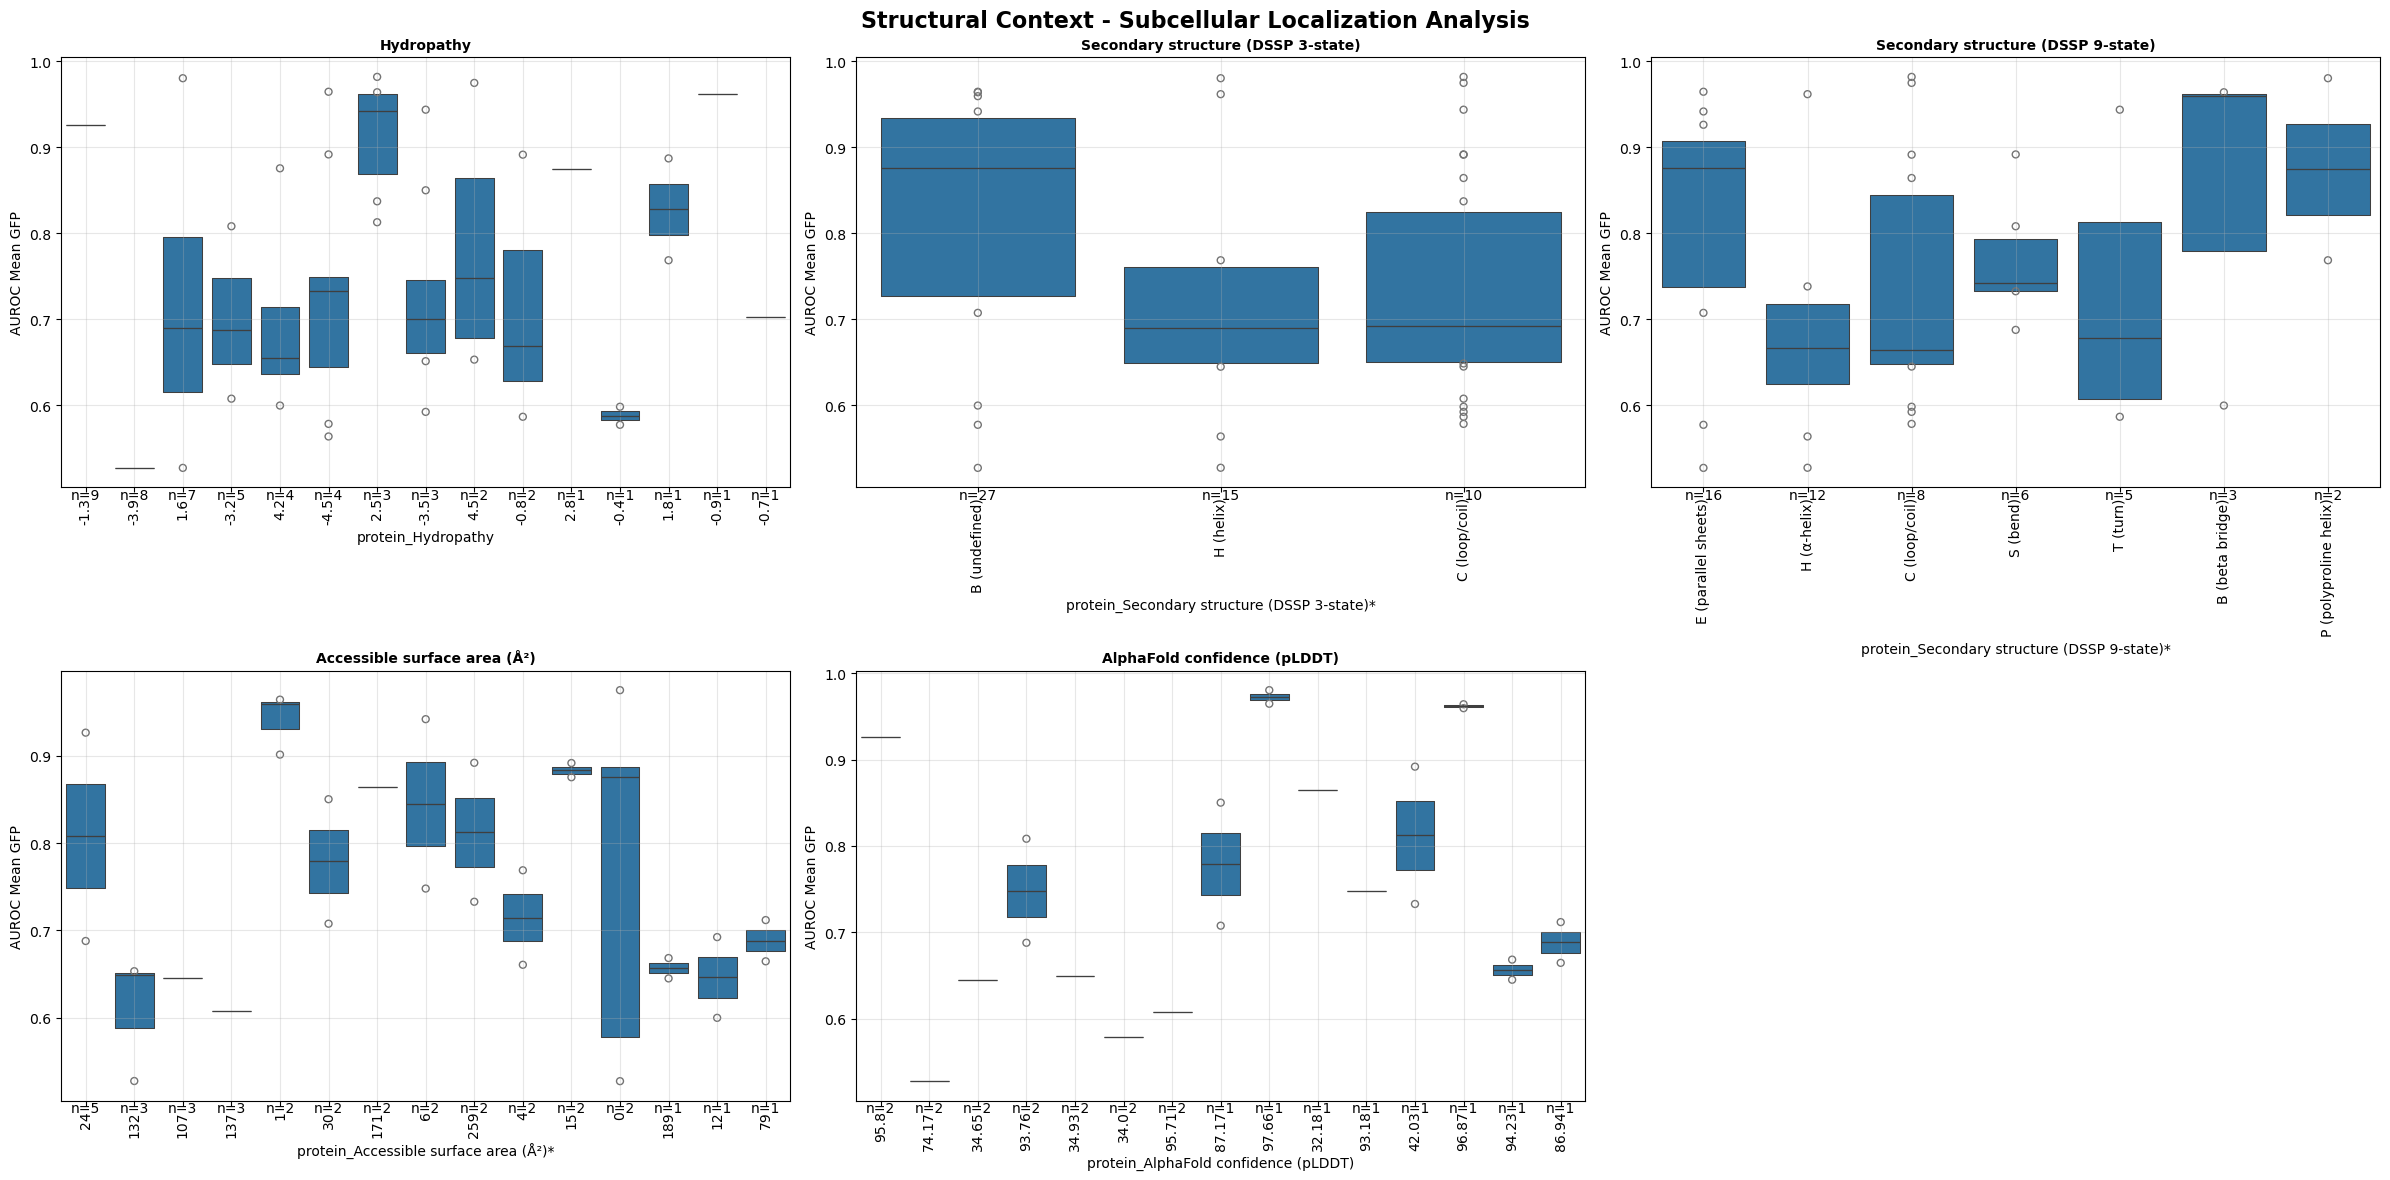


Structural Context Summary:
Features analyzed: 5
  protein_Hydropathy: categorical, 52 non-null values
  protein_Secondary structure (DSSP 3-state)*: categorical, 52 non-null values
  protein_Secondary structure (DSSP 9-state)*: categorical, 52 non-null values
  protein_Accessible surface area (Å²)*: categorical, 52 non-null values
  protein_AlphaFold confidence (pLDDT): categorical, 52 non-null values

ANALYZING: Protein Domains Sites


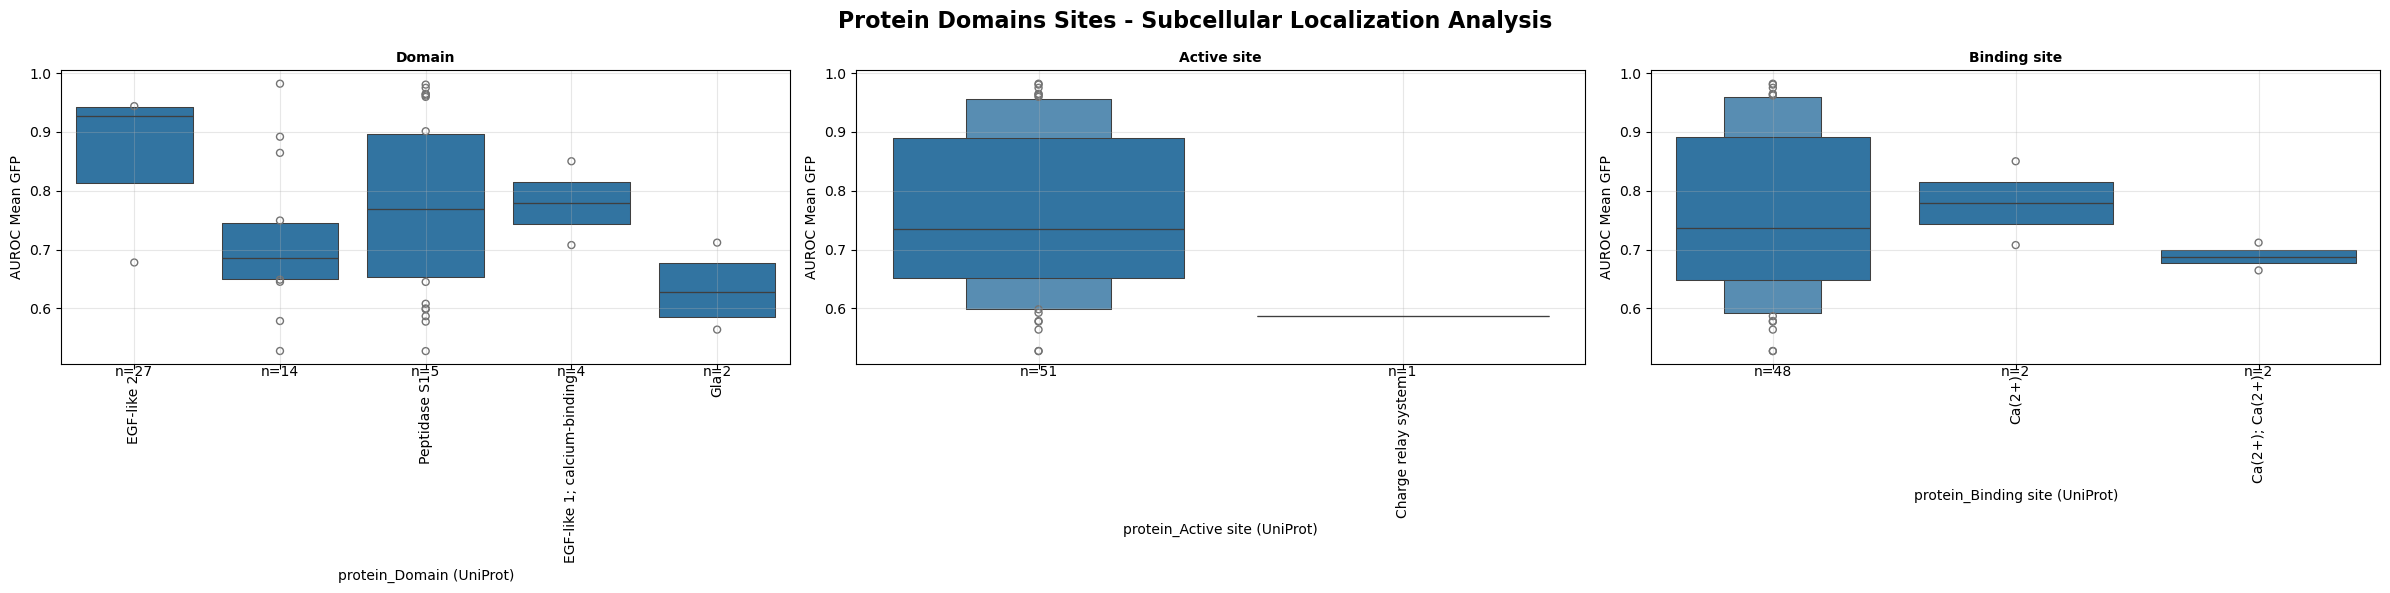


Protein Domains Sites Summary:
Features analyzed: 3
  protein_Domain (UniProt): categorical, 52 non-null values
  protein_Active site (UniProt): categorical, 52 non-null values
  protein_Binding site (UniProt): categorical, 52 non-null values


In [40]:
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = imaging_summary_prot_df

# Define feature categories for subcellular localization analysis
feature_categories = {
    'Signal_Sequences_Targeting': [
        'protein_Signal (UniProt)',
        # 'protein_Transit peptide (UniProt)', 
        # 'protein_Transmembrane (UniProt)',
        # 'protein_Topological domain (UniProt)',
        # 'protein_Intramembrane (UniProt)'
    ],
    
    # 'Nuclear_Targeting': [
    #     'protein_Motif (UniProt)',
    #     'protein_Region (UniProt)'
    # ],
    
    'Structural_Context': [
        'protein_Hydropathy',
        'protein_Secondary structure (DSSP 3-state)*',
        'protein_Secondary structure (DSSP 9-state)*',
        # 'protein_Accessible surface area (Å²)*',
        # 'protein_AlphaFold confidence (pLDDT)'
    ],
    
    # 'Post_Translational_Modifications': [
    #     'protein_Lipidation (UniProt)',
    #     'protein_Glycosylation (UniProt)',
    #     'protein_Modified residue (UniProt)',
    #     'protein_Acetylation',
    #     'protein_Phosphorylation',
    #     'protein_Ubiquitination'
    # ],
    
    'Protein_Domains_Sites': [
        'protein_Domain (UniProt)',
        'protein_Active site (UniProt)',
        'protein_Binding site (UniProt)',
        # 'protein_Coiled coil (UniProt)',
        # 'protein_Zinc finger (UniProt)'
    ]
}

def determine_feature_type(df, feature):
    """Determine if feature is categorical or continuous"""
    if feature not in df.columns:
        return None
    
    # Get non-null values
    values = df[feature].dropna()
    if len(values) == 0:
        return None
    
    # Check if numeric
    if pd.api.types.is_numeric_dtype(values):
        return 'continuous'
    else:
        return 'categorical'

        
def clean_categorical_data(series, max_categories=15):
    """Clean categorical data for plotting"""
    # Remove null values
    cleaned = series.dropna()
    
    # Get value counts
    value_counts = cleaned.value_counts()
    
    # If too many categories, keep top N
    if len(value_counts) > max_categories:
        top_categories = value_counts.head(max_categories).index
        cleaned = cleaned[cleaned.isin(top_categories)]
    
    return cleaned


def format_long_string(text, max_chars=50):
    """Format long strings with line breaks at word boundaries"""
    if len(str(text)) <= max_chars:
        return str(text)
    
    words = str(text).split()
    lines = []
    current_line = ""
    
    for word in words:
        if len(current_line) == 0:
            current_line = word
        elif len(current_line) + len(word) + 1 <= max_chars:
            current_line += " " + word
        else:
            lines.append(current_line)
            current_line = word
    
    if current_line:
        lines.append(current_line)
    
    return "\n".join(lines)


def plot_category_analysis(df, category_name, features, figsize_per_plot=(8, 6)):
    """Plot analysis for a category of features"""
    # Filter valid features
    valid_features = [f for f in features if f in df.columns]
    if not valid_features:
        print(f"No valid features found for {category_name}")
        return
    
    # Calculate subplot layout
    n_features = len(valid_features)
    n_cols = min(3, n_features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows))
    if n_features == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = [axes] if n_features == 1 else axes
    else:
        axes = axes.flatten()
    
    fig.suptitle(f'{category_name.replace("_", " ")} - Subcellular Localization Analysis', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    for i, feature in enumerate(valid_features):
        ax = axes[i]
        
        # Determine feature type
        feature_type = determine_feature_type(df, feature)
        
        if feature_type is None:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(feature.replace('protein_', '').replace(' (UniProt)', ''), fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])
            continue
        
        try:
            if feature_type == 'categorical':
                # For categorical features: boxenplot of AUROC_Mean_GFP per category
                plot_data = df[[feature, 'AUROC_Mean_GFP']].dropna()
                if len(plot_data) == 0:
                    ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes, fontsize=12)
                    ax.set_xticks([])
                    ax.set_yticks([])
                else:
                    # Clean categorical data
                    cleaned_feature = clean_categorical_data(plot_data[feature])
                    plot_data_clean = plot_data[plot_data[feature].isin(cleaned_feature)]
                    if len(plot_data_clean) == 0:
                        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes, fontsize=12)
                        ax.set_xticks([])
                        ax.set_yticks([])
                    else:
                        # Format long category labels
                        plot_data_clean = plot_data_clean.copy()
                        plot_data_clean[feature] = plot_data_clean[feature].apply(format_long_string)
                        
                        sns.boxenplot(data=plot_data_clean, x=feature, y='AUROC_Mean_GFP', ax=ax)
                        ax.tick_params(axis='x', rotation=90, labelsize=10)
                        ax.set_ylabel('AUROC Mean GFP')
                        
                        # Add sample sizes
                        cat_counts = plot_data_clean[feature].value_counts()
                        for j, (cat, count) in enumerate(cat_counts.items()):
                            ax.text(j, ax.get_ylim()[0]-1e-4, f'n={count}', ha='center', va='top', fontsize=10)
            
            else:  # continuous
                # For continuous features: boxenplot per Altered_95th_perc_both_batches_GFP category
                plot_data = df[[feature, 'Altered_95th_perc_both_batches_GFP']].dropna()
                
                if len(plot_data) == 0:
                    ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes, fontsize=10)
                    ax.set_xticks([])
                    ax.set_yticks([])
                else:
                    # Format long category labels
                    plot_data = plot_data.copy()
                    plot_data['Altered_95th_perc_both_batches_GFP'] = plot_data['Altered_95th_perc_both_batches_GFP'].apply(format_long_string)
                    
                    sns.boxenplot(data=plot_data, x='Altered_95th_perc_both_batches_GFP', y=feature, ax=ax)
                    ax.set_xlabel('Altered 95th Perc GFP')
                    ax.tick_params(axis='x', rotation=90, labelsize=10)
                    
                    # Add sample sizes
                    cat_counts = plot_data['Altered_95th_perc_both_batches_GFP'].value_counts()
                    for j, (cat, count) in enumerate(cat_counts.items()):
                        ax.text(j, ax.get_ylim()[0]-1e-4, f'n={count}', ha='center', va='top', fontsize=10)
    
        except Exception as e:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes, fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])
            print(f"Error plotting {feature}: {e}")
        
        # Clean up title
        clean_title = feature.replace('protein_', '').replace(' (UniProt)', '').replace('*', '')
        ax.set_title(clean_title, fontsize=10, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(len(valid_features), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{category_name.replace('_', ' ')} Summary:")
    print(f"Features analyzed: {len(valid_features)}")
    
    for feature in valid_features:
        feature_type = determine_feature_type(df, feature)
        non_null_count = df[feature].notna().sum()
        print(f"  {feature}: {feature_type}, {non_null_count} non-null values")

# Print the feature categories dictionary
print("Feature Categories for Subcellular Localization Analysis:")
print("=" * 60)
for category, features in feature_categories.items():
    print(f"\n{category.replace('_', ' ')}:")
    for feature in features:
        print(f"  - {feature}")

print(f"\nDataset shape: {df.shape}")
print(f"AUROC_Mean_GFP range: {df['AUROC_Mean_GFP'].min():.3f} - {df['AUROC_Mean_GFP'].max():.3f}")
print(f"Altered_95th_perc_both_batches_GFP categories: {df['Altered_95th_perc_both_batches_GFP'].value_counts()}")

# Run analysis for each category
for category_name, features in feature_categories.items():
    print(f"\n{'='*80}")
    print(f"ANALYZING: {category_name.replace('_', ' ')}")
    print(f"{'='*80}")
    plot_category_analysis(df, category_name, features)